# Named Entity Recognition- FYP

CRF:
It is final, tried all L1,L2 coefficients, tried different max_iterations


LSTM+CRF:
1. Tried increasing and decreasing embedding size
2. introduced more complexity by adding another layer(can work)
3. Changed Optimizers
4. Custom CRF loss function (might work)
5. Trained for more epochs(10)

Remove the padding at the time of the classification report, padding casues the O's to increase and also change the padding to some new word such as [PaAD] it shouldn't influence the mdoel

In [ ]:
!pip install python-crfsuite tensorflow_addons git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-00qk0ex4
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-00qk0ex4
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 27.0 MB/s eta 0:00:00
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=79634098323fcfa0a90bed086028376bfb9e753657f869832462b45605fcc0f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ns51hwsc/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from google.colab import drive
from zipfile import ZipFile
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
from keras import backend as K
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load the dataset from Google Drive

In [ ]:
drive_path='/content/gdrive/MyDrive/NER/'

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
zp=ZipFile(drive_path+'dataset.zip')
zp.extractall('/content/')
zp.close()

## Loading the dataset

In [ ]:
tag_path='train_complete/IOB.tags/'
sen_path="train_complete/IOB.words/"
pos_path="train_complete/IOB_PS/"

In [ ]:
filenames=os.listdir("train_complete/IOB.tags")

In [ ]:
sentence_count=0
list_of_words_tags=[]
for i,file in enumerate(filenames):
    posfile=open(pos_path+file,encoding="utf-8")
    tagfile,senfile=open(tag_path+file,encoding="utf-8"),open(sen_path+file,encoding="utf-8")
    list_tags=tagfile.readlines()
    list_sens=senfile.readlines()
    list_pos=posfile.readlines()
    list_pos=[line for line in list_pos if line.strip()]
    pos_count=0
    for y,z in zip(list_tags,list_sens):
        sentence_count+=1
        for tag,word in zip(y.strip().split(),z.strip().split()):
                list_of_words_tags.append([i,file,sentence_count,word,
                                           tag,list_pos[pos_count].strip().split()[1]])
                pos_count+=1

In [ ]:
data=pd.DataFrame(list_of_words_tags,columns=['File Number','File','Sentence','word','tag','pos'])

## Explore The Dataset

In [ ]:
data.head(5)

,File Number,File,Sentence,word,tag,pos
0,0,An_overlapping_community_detection_algorithm_b...,1,The,O,DT
1,0,An_overlapping_community_detection_algorithm_b...,1,growth,O,NN
2,0,An_overlapping_community_detection_algorithm_b...,1,of,O,IN
3,0,An_overlapping_community_detection_algorithm_b...,1,networks,O,NNS
4,0,An_overlapping_community_detection_algorithm_b...,1,is,O,VBZ


In [ ]:
data.tail(10)

,File Number,File,Sentence,word,tag,pos
409006,59,Improving_head_pose_estimation_using_two-stage...,18768,51675265,O,CD
409007,59,Improving_head_pose_estimation_using_two-stage...,18768,),O,)
409008,59,Improving_head_pose_estimation_using_two-stage...,18768,",",O,","
409009,59,Improving_head_pose_estimation_using_two-stage...,18768,and,O,CC
409010,59,Improving_head_pose_estimation_using_two-stage...,18768,the,O,DT
409011,59,Improving_head_pose_estimation_using_two-stage...,18768,(,O,(
409012,59,Improving_head_pose_estimation_using_two-stage...,18768,grant,O,JJ
409013,59,Improving_head_pose_estimation_using_two-stage...,18768,PAPD,B-Organization,NNP
409014,59,Improving_head_pose_estimation_using_two-stage...,18768,),O,)
409015,59,Improving_head_pose_estimation_using_two-stage...,18768,.,O,.


In [ ]:
data['tag'].value_counts()

O                   350870
I-O_Result            9403
I-O_Process           9375
I-B_Process           8709
B-O_Process           4695
I-B_Problem           2875
B-B_Process           2865
I-O_Material          2776
I-O_Problem           2531
I-O_Measure           1594
B-O_Material          1361
I-B_Result            1127
B-O_Problem           1080
I-O_FutureWork        1018
B-O_Measure            996
B-O_Result             973
B-B_Problem            840
I-O_Aim                780
I-B_Material           759
I-O_Gap                725
I-B_Limitation         624
I-O_Limitation         330
I-B_Domain             291
B-B_Material           263
I-Organization         224
I-B_Measure            171
I-O_Domain             169
I-O_Motivation         167
B-B_Result             160
B-O_Domain             134
I-O_Organization       127
B-O_FutureWork         116
I-O_Location           112
B-B_Measure            102
B-B_Domain              86
B-B_Limitation          77
B-O_Aim                 74
I

In [ ]:
#total number of unique files
data["File"].nunique()

60

In [ ]:
#total number of unique words
data['word'].nunique()

18197

In [ ]:
#total number of unique pos
data['pos'].nunique()

44

<Axes: >

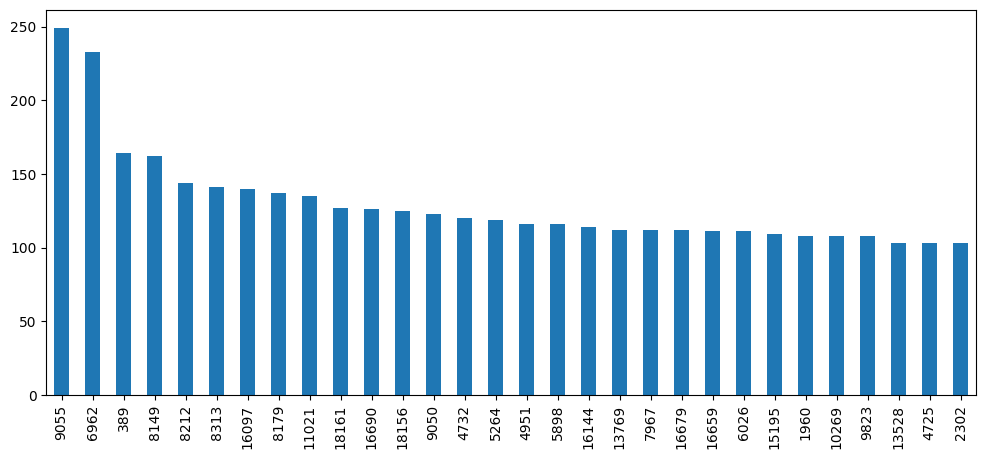

In [ ]:
#No of words per sentence, top 30 displayed
plt.figure(figsize=(12,5))
data['Sentence'].value_counts().sort_values(ascending=False).head(30).plot(kind='bar')

<Axes: >

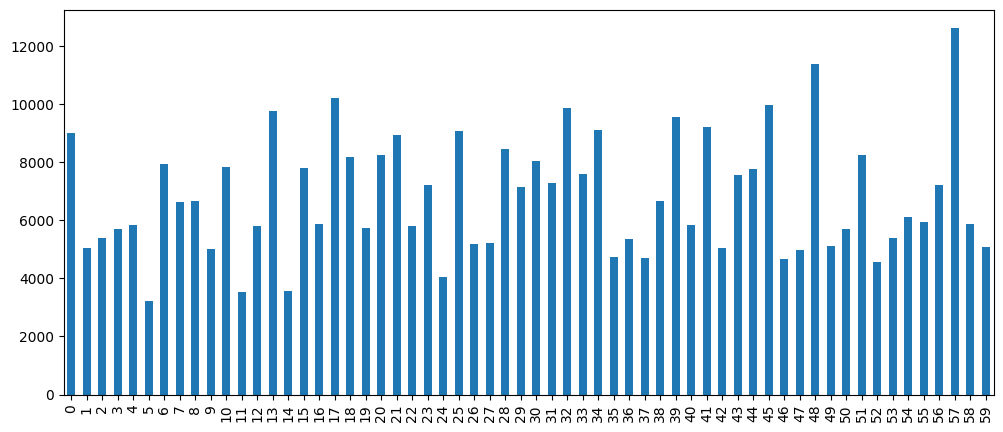

In [ ]:
#No of entries per file
plt.figure(figsize=(12,5))
data['File Number'].value_counts().sort_index().plot(kind='bar')

<Axes: >

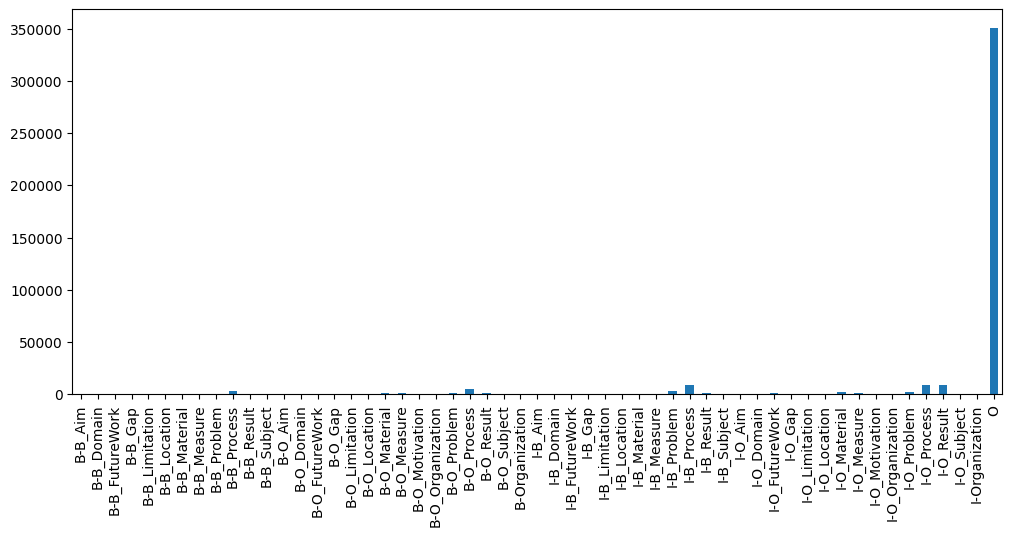

In [ ]:
#No of entries per tag
plt.figure(figsize=(12,5))
data['tag'].value_counts().sort_index().plot(kind='bar')

<Axes: >

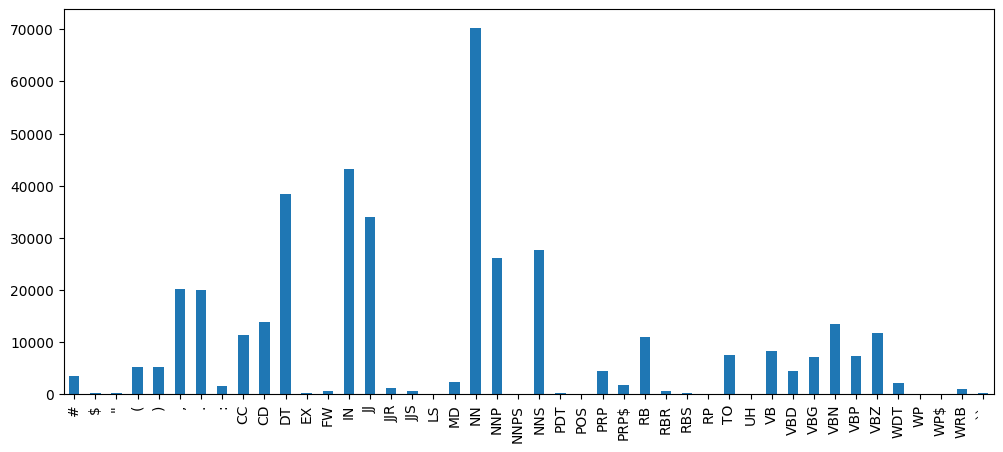

In [ ]:
#No of entries per pos label
plt.figure(figsize=(12,5))
data['pos'].value_counts().sort_index().plot(kind='bar')

In [ ]:
data[data['File Number']==59].head(5)

,File Number,File,Sentence,word,tag,pos
403931,59,Improving_head_pose_estimation_using_two-stage...,18499,Conventional,B-B_Process,JJ
403932,59,Improving_head_pose_estimation_using_two-stage...,18499,head,I-B_Process,NN
403933,59,Improving_head_pose_estimation_using_two-stage...,18499,pose,I-B_Process,JJ
403934,59,Improving_head_pose_estimation_using_two-stage...,18499,estimation,I-B_Process,NN
403935,59,Improving_head_pose_estimation_using_two-stage...,18499,methods,I-B_Process,NNS


In [ ]:
#checking null values
data.isnull().sum()

File Number    0
File           0
Sentence       0
word           0
tag            0
pos            0
dtype: int64

## Preprocessing the dataset

In [ ]:
#get the number of unique words and tags
words = list(set(data['word'].values))
num_words = len(words)
tags = list(set(data['tag'].values))#iob2 tags
num_tags = len(tags)
pos = list(set(data['pos'].values))#iob2 tags
num_pos = len(pos)

In [ ]:
num_words,num_tags,num_pos

(18197, 55, 44)

In [ ]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        # Syntax of --> lambda arguments : expression
        # zip () generates tuples
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['word'].values.tolist(),
                                                          s['pos'].values.tolist(),
                                                          s['tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('The', 'DT', 'O'),
 ('growth', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('networks', 'NNS', 'O'),
 ('is', 'VBZ', 'O'),
 ('prevalent', 'JJ', 'O'),
 ('in', 'IN', 'O'),
 ('almost', 'RB', 'O'),
 ('every', 'DT', 'O'),
 ('field', 'NN', 'O'),
 ('due', 'JJ', 'O'),
 ('to', 'TO', 'O'),
 ('the', 'DT', 'O'),
 ('digital', 'JJ', 'O'),
 ('transformation', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('consumers', 'NNS', 'O'),
 (',', ',', 'O'),
 ('business', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('society', 'NN', 'O'),
 ('at', 'IN', 'O'),
 ('large', 'JJ', 'O'),
 ('.', '.', 'O')]

In [ ]:
len_sen=[len(s) for s in sentences]

In [ ]:
import numpy as np
max_len=int(np.percentile(len_sen,99.8))
max_len

98

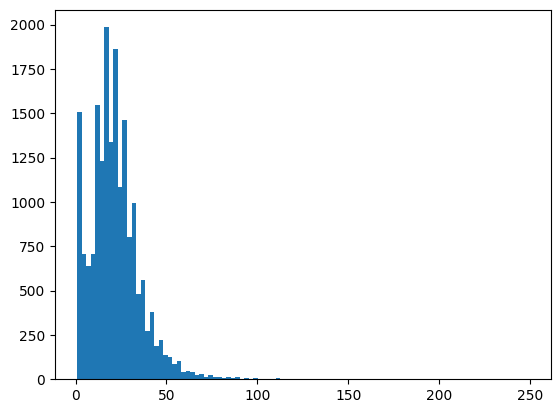

In [ ]:
import matplotlib.pyplot as plt
plt.hist(len_sen, bins=100)
plt.show()

## Function to preprocess the given data (i.e. idx,pad and split)

In [ ]:
def process_training_data(sentences,words,tags,pos,len_sen):
  #get the number of unique words and tags
  words = list(set(data['word'].values))
  num_words = len(words)
  tags = list(set(data['tag'].values))#iob2 tags
  num_tags = len(tags)
  pos = list(set(data['pos'].values))#iob2 tags
  num_pos = len(pos)
  #unique id for each word tag and pos
  word2idx = {w: i for i, w in enumerate(words)}
  tag2idx = {t: i for i, t in enumerate(tags)}
  pos2idx = {pos: id for id, pos in enumerate(pos)}
  #calc max sentence length
  max_len=int(np.percentile(len_sen,99.8))
  #add numbers to the sequences to make them all be the same length.
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)#35177
  y = [[tag2idx[w[2]] for w in s] for s in sentences]
  y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])#5
  y = [to_categorical(i, num_classes=num_tags) for i in y]
  y=np.array(y)
  X,y=shuffle(X,y,random_state=42)
  xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15,shuffle=False,random_state=42)
  return xtrain,xtest,ytrain,ytest

## Creating a Train test Dataset

In [ ]:
xtrain,xtest,ytrain,ytest=process_training_data(sentences,words,tags,pos,len_sen)

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
val_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest))
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Focal Loss function for categorical

In [ ]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

# Models on all 54 Tags

## Model 1: LSTM based

In [ ]:
inputs = Input(shape=(max_len, ))
embedding = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
lstm1 = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(embedding)
lstm2 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm1)
lstm3 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm2)
outputs = TimeDistributed(Dense(num_tags, activation='softmax'))(lstm3)
all_tags_model1 = Model(inputs, outputs)
all_tags_model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_3 (Bidirectio  (None, 98, 128)          62976     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 98, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 98, 128)          74496     
 nal)                                                            
                                                           

In [ ]:
all_tags_model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=focal_loss(),
              metrics=['accuracy'])

In [ ]:
all_tags_history1 = all_tags_model1.fit(train_dataset,
                                        epochs=5,
                                        validation_data=val_dataset)

Epoch 1/5
499/499 [==============================] - 47s 71ms/step - loss: 9.0524e-04 - accuracy: 0.9672 - val_loss: 5.8239e-04 - val_accuracy: 0.9684
Epoch 2/5
499/499 [==============================] - 13s 25ms/step - loss: 4.8120e-04 - accuracy: 0.9714 - val_loss: 4.8647e-04 - val_accuracy: 0.9710
Epoch 3/5
499/499 [==============================] - 13s 26ms/step - loss: 3.7576e-04 - accuracy: 0.9749 - val_loss: 4.5165e-04 - val_accuracy: 0.9708
Epoch 4/5
499/499 [==============================] - 13s 26ms/step - loss: 2.8273e-04 - accuracy: 0.9790 - val_loss: 4.5459e-04 - val_accuracy: 0.9737
Epoch 5/5
499/499 [==============================] - 14s 29ms/step - loss: 2.1710e-04 - accuracy: 0.9830 - val_loss: 5.2841e-04 - val_accuracy: 0.9749


In [ ]:
all_tags_model1.evaluate(xtest,ytest)

88/88 [==============================] - 1s 11ms/step - loss: 5.2841e-04 - accuracy: 0.9749


[0.00052841060096398, 0.9749318957328796]

In [ ]:
def get_flattened_preds(model,xtest,ytest):
  pred_probs=model.predict(xtest)
  preds=tf.argmax(pred_probs,axis=-1)
  y_true=[tf.argmax(x,axis=-1).numpy() for x in ytest]
  y_true=np.array(y_true).reshape(preds.shape[0]*preds.shape[1])
  y_pred=preds.numpy().reshape(preds.shape[0]*preds.shape[1])
  return y_true,y_pred

In [ ]:
y_true,y_pred=get_flattened_preds(all_tags_model1,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 1s 10ms/step
                  precision    recall  f1-score   support

      B-O_Result       0.47      0.16      0.24       139
     B-B_Measure       0.00      0.00      0.00        19
  I-O_Limitation       0.00      0.00      0.00        40
      I-O_Result       0.52      0.28      0.37      1364
    B-O_Location       0.00      0.00      0.00        10
  I-O_FutureWork       0.00      0.00      0.00       179
    B-B_Location       0.00      0.00      0.00         6
      B-B_Domain       0.00      0.00      0.00        13
  B-O_Motivation       0.00      0.00      0.00         2
  I-O_Motivation       0.00      0.00      0.00        19
               O       0.98      1.00      0.99    266891
  B-B_Limitation       0.00      0.00      0.00        14
      I-O_Domain       0.00      0.00      0.00        16
B-O_Organization       0.00      0.00      0.00         5
  B-O_FutureWork       0.00      0.00      0.00        19
    I-B_Location 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
def get_pred_sentence(model,xtest,words,tags):
  i = np.random.randint(0, xtest.shape[0])

  p = model.predict(np.array([xtest[i]]))
  p = tf.argmax(p, axis=-1)
  y_true = np.argmax(np.array(ytest), axis=-1)[i]
  print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
  print('-'*30)
  for w, true, pred in zip(xtest[i], y_true, p[0]):
      print('{:15}{}\t{}'.format(words[w], tags[true], tags[pred]))

In [ ]:
get_pred_sentence(all_tags_model1,xtest,words,tags)

1/1 [==============================] - 2s 2s/step
Word           True 	 Pred

------------------------------
It             O	O
is             O	O
partially      O	O
because        O	O
the            O	O
large          O	O
number         O	O
of             O	O
the            O	O
categories     O	O
,              O	O
in             O	O
which          O	O
many           O	O
actions        O	O
show           O	O
similar        O	O
motion         O	O
patterns       O	O
.              O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	

In [ ]:
all_tags_model1_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                          target_names=tags,
                                                          labels=np.arange(0,len(tags),1),
                                                          output_dict=True)).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

## Custom CRF Class

In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

## Model 2: Using LSTM+CRF

In [ ]:
inputs = Input(shape=(max_len, ))
embedding = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
lstm1 = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(embedding)
lstm2 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm1)
logits = TimeDistributed(Dense(num_tags))(lstm2)
crf_layer = CRF(num_tags)
outputs= crf_layer(logits)
all_tags_model2 = Model(inputs, outputs)
all_tags_model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_6 (Bidirectio  (None, 98, 128)          62976     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 98, 128)          74496     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 98, 55)           7095      
 tributed)                                                       
                                                           

In [ ]:
all_tags_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=crf_layer.loss,
                        metrics=[crf_layer.accuracy])

In [ ]:
all_tags_history2 = all_tags_model2.fit(train_dataset,
                                        epochs=5,
                                        validation_data=val_dataset)

Epoch 1/5
499/499 [==============================] - 189s 353ms/step - loss: 21.2686 - viterbi_accuracy: 0.9671 - val_loss: 279.2802 - val_viterbi_accuracy: 0.9698
Epoch 2/5
499/499 [==============================] - 148s 296ms/step - loss: 8.6463 - viterbi_accuracy: 0.9737 - val_loss: 273.3744 - val_viterbi_accuracy: 0.9713
Epoch 3/5
499/499 [==============================] - 146s 293ms/step - loss: 5.6227 - viterbi_accuracy: 0.9789 - val_loss: 267.8602 - val_viterbi_accuracy: 0.9740
Epoch 4/5
499/499 [==============================] - 147s 294ms/step - loss: 3.7250 - viterbi_accuracy: 0.9841 - val_loss: 263.2846 - val_viterbi_accuracy: 0.9739
Epoch 5/5
499/499 [==============================] - 152s 305ms/step - loss: 2.7045 - viterbi_accuracy: 0.9874 - val_loss: 258.9907 - val_viterbi_accuracy: 0.9753


In [ ]:
all_tags_model2.evaluate(val_dataset)

88/88 [==============================] - 14s 162ms/step - loss: 258.9907 - viterbi_accuracy: 0.9753


[258.99072265625, 0.975272536277771]

In [ ]:
y_true,y_pred=get_flattened_preds(all_tags_model2,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 10s 119ms/step
                  precision    recall  f1-score   support

      B-O_Result       0.49      0.29      0.36       139
     B-B_Measure       0.00      0.00      0.00        19
  I-O_Limitation       0.00      0.00      0.00        40
      I-O_Result       0.57      0.35      0.43      1364
    B-O_Location       1.00      0.10      0.18        10
  I-O_FutureWork       0.00      0.00      0.00       179
    B-B_Location       0.00      0.00      0.00         6
      B-B_Domain       1.00      0.08      0.14        13
  B-O_Motivation       0.00      0.00      0.00         2
  I-O_Motivation       0.00      0.00      0.00        19
               O       0.99      0.99      0.99    266891
  B-B_Limitation       0.00      0.00      0.00        14
      I-O_Domain       1.00      0.06      0.12        16
B-O_Organization       0.00      0.00      0.00         5
  B-O_FutureWork       0.00      0.00      0.00        19
    I-B_Locatio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
all_tags_model2_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                          target_names=tags,
                                                          output_dict=True,
                                                          labels=np.arange(0,len(tags),1))).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

## Preprocessing data for CRF

### Preprocessing functions: word2features, get_labels, extract_features

In [ ]:
def word2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]

    # Common features for all words
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag
    ]

    # Features for words that are not
    # at the beginning of a document
    if i > 0:
        word1 = doc[i-1][0]
        postag1 = doc[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.isdigit=%s' % word1.isdigit(),
            '-1:postag=' + postag1
        ])
    else:
        # Indicate that it is the 'beginning of a document'
        features.append('BOS')

    # Features for words that are not
    # at the end of a document
    if i < len(doc)-1:
        word1 = doc[i+1][0]
        postag1 = doc[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.isdigit=%s' % word1.isdigit(),
            '+1:postag=' + postag1
        ])
    else:
        # Indicate that it is the 'end of a document'
        features.append('EOS')

    return features

In [ ]:
from sklearn.model_selection import train_test_split

# A function for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

# A function fo generating the list of labels for each document
def get_labels(doc):
    return [label for (token, postag, label) in doc]

def crf_split(sentences):
  X = [extract_features(doc) for doc in sentences]
  y = [get_labels(doc) for doc in sentences]
  X,y=shuffle(X,y,random_state=42)
  xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15,shuffle=False)
  return xtrain,xtest,ytrain,ytest


## Model 3: Using CRFs

In [ ]:
xtrain, xtest, ytrain, ytest=crf_split(sentences)

In [ ]:
import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)
# Submit training data to the trainer
for xseq,yseq in zip(xtrain,ytrain):
    trainer.append(xseq,yseq)

In [ ]:
# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.1,

    # coefficient for L2 penalty
    'c2': 0.01,

    # maximum number of iterations
    'max_iterations': 200,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Provide a file name as a parameter to the train function, such that
# the model will be saved to the file when training is finished
trainer.train('crf_all_tags.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 101584
Seconds required: 0.840

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 549039.535222
Feature norm: 1.000000
Error norm: 636780.387753
Active features: 100337
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 5.987

***** Iteration #2 *****
Loss: 516018.970148
Feature norm: 3.292522
Error norm: 167083.029874
Active features: 97874
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 4.330

***** Iteration #3 *****
Loss: 442239.915840
Feature norm: 2.860831
Error norm: 162964.095875
Active features: 95380
Line search trials: 1
Line search step: 1.000000
Seconds requ

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_all_tags.model')

In [ ]:
# Convert the sequences of tags into a 1-dimensional array
ypred = [tagger.tag(xseq) for xseq in xtest]
predictions = np.array([tag for row in ypred for tag in row])
truths = np.array([tag for row in ytest for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-B_Aim       0.00      0.00      0.00         2
      B-B_Domain       0.29      0.15      0.20        13
  B-B_Limitation       0.00      0.00      0.00        14
    B-B_Location       0.00      0.00      0.00         6
    B-B_Material       0.54      0.33      0.41        43
     B-B_Measure       0.25      0.11      0.15        19
     B-B_Problem       0.43      0.34      0.38       131
     B-B_Process       0.56      0.48      0.52       451
      B-B_Result       0.29      0.06      0.10        32
         B-O_Aim       0.14      0.08      0.11        12
      B-O_Domain       0.44      0.39      0.41        18
  B-O_FutureWork       0.25      0.11      0.15        19
         B-O_Gap       0.00      0.00      0.00         9
  B-O_Limitation       0.00      0.00      0.00         4
    B-O_Location       0.57      0.40      0.47        10
    B-O_Material       0.78      0.59      0.68       224
     B-O_Meas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
all_tags_model3_report=pd.DataFrame(classification_report(truths, predictions,output_dict=True)).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Combining the Tag Labels

In [ ]:
data['tag'].nunique()

55

In [ ]:
data['tag'].value_counts()

O                   350870
I-O_Result            9403
I-O_Process           9375
I-B_Process           8709
B-O_Process           4695
I-B_Problem           2875
B-B_Process           2865
I-O_Material          2776
I-O_Problem           2531
I-O_Measure           1594
B-O_Material          1361
I-B_Result            1127
B-O_Problem           1080
I-O_FutureWork        1018
B-O_Measure            996
B-O_Result             973
B-B_Problem            840
I-O_Aim                780
I-B_Material           759
I-O_Gap                725
I-B_Limitation         624
I-O_Limitation         330
I-B_Domain             291
B-B_Material           263
I-Organization         224
I-B_Measure            171
I-O_Domain             169
I-O_Motivation         167
B-B_Result             160
B-O_Domain             134
I-O_Organization       127
B-O_FutureWork         116
I-O_Location           112
B-B_Measure            102
B-B_Domain              86
B-B_Limitation          77
B-O_Aim                 74
I

In [ ]:
def combine_tags(tag):
  if '_' in tag:
    tok=tag.split('_')
    return tok[0][0]+'_'+tok[1]
  return tag

data['tag']=data['tag'].apply(combine_tags)

In [ ]:
data['tag'].nunique()

31

In [ ]:
data['tag'].value_counts()

O                 350870
I_Process          18084
I_Result           10530
B_Process           7560
I_Problem           5406
I_Material          3535
B_Problem           1920
I_Measure           1765
B_Material          1624
B_Result            1133
B_Measure           1098
I_FutureWork        1024
I_Limitation         954
I_Aim                850
I_Gap                744
I_Domain             460
I-Organization       224
B_Domain             220
I_Motivation         167
I_Organization       127
I_Location           121
B_FutureWork         117
B_Limitation         116
B_Aim                 86
B_Location            79
B-Organization        68
B_Gap                 65
B_Organization        29
I_Subject             14
B_Motivation          13
B_Subject             13
Name: tag, dtype: int64

In [ ]:
data['tag'].replace("I-Organization","I_Organization",inplace=True)
data['tag'].replace("B-Organization","B_Organization",inplace=True)

In [ ]:
data['tag'].value_counts()

O                 350870
I_Process          18084
I_Result           10530
B_Process           7560
I_Problem           5406
I_Material          3535
B_Problem           1920
I_Measure           1765
B_Material          1624
B_Result            1133
B_Measure           1098
I_FutureWork        1024
I_Limitation         954
I_Aim                850
I_Gap                744
I_Domain             460
I_Organization       351
B_Domain             220
I_Motivation         167
I_Location           121
B_FutureWork         117
B_Limitation         116
B_Organization        97
B_Aim                 86
B_Location            79
B_Gap                 65
I_Subject             14
B_Motivation          13
B_Subject             13
Name: tag, dtype: int64

# Models using 31 Tags

## Preparing the dataset

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
len_sen=[len(s) for s in sentences]

In [ ]:
import numpy as np
max_len=int(np.percentile(len_sen,99.8))
max_len

98

In [ ]:
num_tags=data['tag'].nunique()

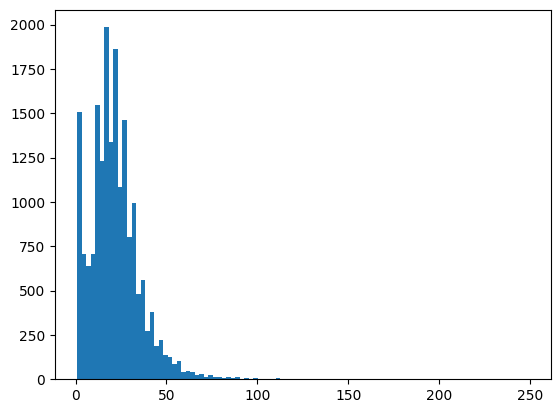

In [ ]:
import matplotlib.pyplot as plt
plt.hist(len_sen, bins=100)
plt.show()

In [ ]:
#get the number of unique words and tags
words = list(set(data['word'].values))
num_words = len(words)
tags = list(set(data['tag'].values))#iob2 tags
num_tags = len(tags)
pos = list(set(data['pos'].values))#iob2 tags
num_pos = len(pos)

### Creating train and test dataset

In [ ]:
xtrain,xtest,ytrain,ytest=process_training_data(sentences,words,tags,pos,len_sen)

In [ ]:
tags_31_train_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
tags_31_val_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest))
tags_31_train_dataset=tags_31_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tags_31_val_dataset=tags_31_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model1: Using LSTM

In [ ]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
x = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(x)
x = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(x)
x = Dense(64, activation='relu')(x)
outputs = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
tags31_model1 = Model(inputs,outputs)
tags31_model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_8 (Bidirectio  (None, 98, 128)          62976     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 98, 128)          74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 98, 64)            8256      
                                                                 
 time_distributed_3 (TimeDis  (None, 98, 29)           1885

In [ ]:
tags31_model1.compile(optimizer='adam', loss=focal_loss(alpha=.45), metrics=['accuracy'])

In [ ]:
import numpy as np
tag31_history1 = tags31_model1.fit(tags_31_train_dataset,
                    epochs = 5,
                    validation_data=tags_31_val_dataset)

Epoch 1/5
499/499 [==============================] - 42s 64ms/step - loss: 0.0026 - accuracy: 0.9682 - val_loss: 0.0015 - val_accuracy: 0.9714
Epoch 2/5
499/499 [==============================] - 9s 18ms/step - loss: 0.0011 - accuracy: 0.9762 - val_loss: 0.0011 - val_accuracy: 0.9760
Epoch 3/5
499/499 [==============================] - 10s 20ms/step - loss: 7.1514e-04 - accuracy: 0.9820 - val_loss: 9.6254e-04 - val_accuracy: 0.9769
Epoch 4/5
499/499 [==============================] - 10s 20ms/step - loss: 4.8856e-04 - accuracy: 0.9862 - val_loss: 0.0011 - val_accuracy: 0.9776
Epoch 5/5
499/499 [==============================] - 9s 18ms/step - loss: 3.6662e-04 - accuracy: 0.9886 - val_loss: 0.0013 - val_accuracy: 0.9780


In [ ]:
from sklearn.metrics import classification_report
y_true,y_pred=get_flattened_preds(tags31_model1,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 1s 8ms/step
                precision    recall  f1-score   support

  B_FutureWork       0.00      0.00      0.00        19
  I_Limitation       0.12      0.01      0.02       147
    B_Material       0.67      0.52      0.58       267
    B_Location       0.00      0.00      0.00        16
  B_Motivation       0.00      0.00      0.00         2
      I_Domain       0.30      0.19      0.23        57
     B_Subject       0.00      0.00      0.00         1
     I_Problem       0.58      0.49      0.53       835
      B_Domain       0.35      0.19      0.25        31
             O       0.99      1.00      0.99    266891
     I_Subject       0.00      0.00      0.00         1
         I_Aim       0.60      0.02      0.04       136
     B_Measure       0.70      0.46      0.55       175
         B_Aim       0.00      0.00      0.00        14
B_Organization       0.00      0.00      0.00        19
      I_Result       0.59      0.34      0.43     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
get_pred_sentence(tags31_model1,xtest,words,tags)

1/1 [==============================] - 0s 25ms/step
Word           True 	 Pred

------------------------------
(              O	O
2016           O	O
)              O	O
explores       O	O
the            O	O
effectiveness  O	O
of             O	O
binary         B_Process	B_Process
class          I_Process	I_Process
imbalanced     I_Process	I_Process
learning       I_Process	I_Process
methods        I_Process	I_Process
UnderBagging   I_Process	I_Process
(              I_Process	O
Barandela      I_Process	O
et             I_Process	O
al             I_Process	O
.              O	O
,              I_Process	O
2003           I_Process	O
)              I_Process	O
,              I_Process	O
SMOTEBagging   I_Process	O
(              I_Process	O
Díez-Pastor    I_Process	O
et             I_Process	O
al             I_Process	I_Process
.              O	O
,              I_Process	O
2015           I_Process	I_Process
)              I_Process	I_Process
,              I_Process	I_Process
RUSBoost       I_

In [ ]:
tags31_model1_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                        target_names=tags,
                                                        output_dict=True,
                                                        labels=np.arange(0,len(tags),1))).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: Using LSTM+CRF

In [ ]:
inputs = Input(shape=(max_len, ))
embedding = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
lstm1 = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(embedding)
lstm2 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm1)
logits = TimeDistributed(Dense(num_tags))(lstm2)
crf_layer = CRF(num_tags)
outputs= crf_layer(logits)
tags31_model2 = Model(inputs, outputs)
tags31_model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_10 (Bidirecti  (None, 98, 128)          62976     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 98, 128)          74496     
 onal)                                                           
                                                                 
 time_distributed_4 (TimeDis  (None, 98, 29)           3741      
 tributed)                                                       
                                                           

In [ ]:
tags31_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=crf_layer.loss,
                        metrics=[crf_layer.accuracy])

In [ ]:
tags31_history2 = tags31_model2.fit(tags_31_train_dataset,
                                        epochs=5,
                                        validation_data=tags_31_val_dataset)

Epoch 1/5
499/499 [==============================] - 190s 360ms/step - loss: 16.7322 - viterbi_accuracy: 0.9711 - val_loss: 204.5211 - val_viterbi_accuracy: 0.9728
Epoch 2/5
499/499 [==============================] - 155s 310ms/step - loss: 6.6666 - viterbi_accuracy: 0.9782 - val_loss: 198.6290 - val_viterbi_accuracy: 0.9764
Epoch 3/5
499/499 [==============================] - 152s 304ms/step - loss: 3.9923 - viterbi_accuracy: 0.9849 - val_loss: 193.6706 - val_viterbi_accuracy: 0.9783
Epoch 4/5
499/499 [==============================] - 163s 326ms/step - loss: 2.6084 - viterbi_accuracy: 0.9889 - val_loss: 189.5755 - val_viterbi_accuracy: 0.9775
Epoch 5/5
499/499 [==============================] - 166s 333ms/step - loss: 1.8424 - viterbi_accuracy: 0.9912 - val_loss: 186.0131 - val_viterbi_accuracy: 0.9774


In [ ]:
tags31_model2.evaluate(tags_31_val_dataset)

88/88 [==============================] - 16s 177ms/step - loss: 186.0131 - viterbi_accuracy: 0.9774


[186.0131378173828, 0.9773923754692078]

In [ ]:
y_true,y_pred=get_flattened_preds(tags31_model2,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 10s 95ms/step
                precision    recall  f1-score   support

  B_FutureWork       0.00      0.00      0.00        19
  I_Limitation       0.00      0.00      0.00       147
    B_Material       0.76      0.56      0.64       267
    B_Location       0.75      0.19      0.30        16
  B_Motivation       0.00      0.00      0.00         2
      I_Domain       0.49      0.39      0.43        57
     B_Subject       0.00      0.00      0.00         1
     I_Problem       0.53      0.53      0.53       835
      B_Domain       0.52      0.39      0.44        31
             O       0.99      0.99      0.99    266891
     I_Subject       0.00      0.00      0.00         1
         I_Aim       0.00      0.00      0.00       136
     B_Measure       0.73      0.61      0.67       175
         B_Aim       0.00      0.00      0.00        14
B_Organization       1.00      0.11      0.19        19
      I_Result       0.56      0.31      0.40   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tags31_model2_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                        target_names=tags,
                                                        output_dict=True,
                                                        labels=np.arange(0,len(tags),1))).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 3: Using CRFs

In [ ]:
xtrain, xtest, ytrain, ytest=crf_split(sentences)

In [ ]:
import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)
# Submit training data to the trainer
for xseq,yseq in zip(xtrain,ytrain):
    trainer.append(xseq,yseq)

In [ ]:
# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.1,

    # coefficient for L2 penalty
    'c2': 0.01,

    # maximum number of iterations
    'max_iterations': 200,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Provide a file name as a parameter to the train function, such that
# the model will be saved to the file when training is finished
trainer.train('crf_31_tags.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 89993
Seconds required: 0.906

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 402629.243332
Feature norm: 1.000000
Error norm: 448675.014936
Active features: 89057
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 3.390

***** Iteration #2 *****
Loss: 321549.546452
Feature norm: 1.982106
Error norm: 138139.542577
Active features: 83433
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 2.075

***** Iteration #3 *****
Loss: 296379.599429
Feature norm: 1.801790
Error norm: 110449.993457
Active features: 87497
Line search trials: 1
Line search step: 1.000000
Seconds requir

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_31_tags.model')

In [ ]:
# Convert the sequences of tags into a 1-dimensional array
ypred = [tagger.tag(xseq) for xseq in xtest]
predictions = np.array([tag for row in ypred for tag in row])
truths = np.array([tag for row in ytest for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         B_Aim       0.25      0.07      0.11        14
      B_Domain       0.52      0.42      0.46        31
  B_FutureWork       0.20      0.05      0.08        19
         B_Gap       0.00      0.00      0.00         9
  B_Limitation       0.25      0.06      0.09        18
    B_Location       0.86      0.38      0.52        16
    B_Material       0.81      0.59      0.68       267
     B_Measure       0.72      0.63      0.67       175
  B_Motivation       0.00      0.00      0.00         2
B_Organization       0.86      0.32      0.46        19
     B_Problem       0.67      0.63      0.65       305
     B_Process       0.76      0.71      0.73      1154
      B_Result       0.37      0.32      0.34       171
     B_Subject       0.00      0.00      0.00         1
         I_Aim       0.23      0.11      0.15       136
      I_Domain       0.48      0.28      0.36        57
  I_FutureWork       0.30      0.09      0.14  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tags31_model3_report=pd.DataFrame(classification_report(truths, predictions,output_dict=True)).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Trying BERT

In [ ]:
tags_list=data.groupby("Sentence")["tag"].apply(list).values
sentence=data.groupby("Sentence")["word"].apply(list).to_numpy()

In [ ]:
sentence_list=[]
for x in sentence:
  sentence_list.append(" ".join(x))

In [ ]:
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
new_list=[]
for tag in tags_list:
  lis=[]
  i=0
  for i in range(0,98):
    if i>=98:
      break;
    if i<len(tag):
      lis.append(tag2idx[tag[i]])
    else:
      lis.append(0)
  new_list.append(lis)

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_text
import tensorflow_hub as hub
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder = hub.KerasLayer(
    "https://tfhub.dev/google/experts/bert/wiki_books/2",
    trainable=False)

In [ ]:
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x= preprocessor(inputs)
x = encoder(x)
x = x["sequence_output"]
x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,activation='tanh'))(x)
x=tf.keras.layers.GRU(49,return_sequences=True,activation='tanh')(x)
x=tf.keras.layers.Reshape(target_shape=(98,64))(x)

x=tf.keras.layers.Dense(64,activation='relu')(x)

outputs=tf.keras.layers.Dense(10,activation='softmax')(x)

key_model2=tf.keras.Model(inputs,outputs)

In [ ]:
key_model2.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.RMSprop(),
               metrics=['accuracy'])

In [ ]:
sentence_list = data.groupby("Sentence")["word"].apply(list).values

In [ ]:
key_model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['input_15[0][0]']               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                               

In [ ]:
from sklearn.model_selection import train_test_split
split=int(0.8*len(sentence_list))
xtrain, xtest, ytrain, ytest=np.asarray(sentence_list)[:split],np.asarray(sentence_list)[split:], tf.one_hot(np.vstack(new_list),depth=10)[:split],tf.one_hot(np.vstack(new_list),depth=10)[split:]

In [ ]:
for i in range(0,len(xtrain)):
  xtrain[i]=xtrain[i]

In [ ]:
xtrain

array(['While the basic laws of Newtonian mechanics are well understood , explaining a physical scenario still requires manually modeling the problem with suitable equations and estimating the associated parameters .',
       'In order to be able to leverage the approximation capabilities of artificial intelligence techniques in such physics related contexts , researchers have handcrafted relevant states , and then used neural networks to learn the state transitions using simulation runs as training data .',
       'Unfortunately , such approaches are unsuited for modeling complex real-world scenarios , where manually authoring relevant state spaces tend to be tedious and challenging .',
       ..., '# EQ .',
       'Relative error vs . number of training queries ; ( left ) Crimes ( right ) Sensors .',
       '5.3 .'], dtype='<U1049')

In [ ]:
key_model2.fit(xtrain,ytrain)

470/470 [==============================] - 186s 373ms/step - loss: 0.1652 - accuracy: 0.9592


In [ ]:
pred_probs=key_model2.predict(xtest)

118/118 [==============================] - 45s 365ms/step


In [ ]:
pred_probs.shape

(3754, 98, 10)

In [ ]:
ytest.shape

TensorShape([3754, 98, 10])

In [ ]:
preds=tf.argmax(pred_probs,axis=-1)

In [ ]:
preds.shape

TensorShape([3754, 98])

In [ ]:
y_true=tf.argmax(ytest,axis=-1)

In [ ]:
y_true.shape

TensorShape([3754, 98])

In [ ]:
y_true=np.array(y_true).reshape(preds.shape[0]*preds.shape[1])
y_pred=preds.numpy().reshape(preds.shape[0]*preds.shape[1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    357181
           1       0.00      0.00      0.00       130
           2       0.00      0.00      0.00       128
           3       0.00      0.00      0.00      1717
           4       0.00      0.00      0.00       376
           5       0.80      0.00      0.00      2306
           6       0.44      0.48      0.46      5311
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00       623
           9       0.00      0.00      0.00       108

    accuracy                           0.97    367892
   macro avg       0.22      0.15      0.14    367892
weighted avg       0.96      0.97      0.96    367892



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Combining Tags to 10

In [ ]:
#Process [Process,Measure]
#Objective [Aim, Objective, Motivation]
#Domain   [Subject,Domain]
#Problem   [Problem,Limitation]
#FutureWork   [Gap,FutureWork]
#Material
#Organization
#Result
#Location
#O

mapping={"Measure":"Process",
         "Aim":"Objective","Motivation":"Objective",
         "Subject":"Domain",
         "Limitation":"Problem",
         "Gap":"FutureWork"}

In [ ]:
def combine_tags(tag):
  if tag=="O":
    return tag
  tag=tag.split("_")[1]
  if mapping.get(tag):
    return mapping[tag]
  return tag

In [ ]:
data['tag']=data['tag'].apply(combine_tags)

In [ ]:
data['tag'].value_counts()

O               350870
Process          28507
Result           11663
Problem           8396
Material          5159
FutureWork        1950
Objective         1116
Domain             707
Organization       448
Location           200
Name: tag, dtype: int64

In [ ]:
data['tag'].nunique()

10

# Models using 10 Tags

## Preparing the dataset

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
len_sen=[len(s) for s in sentences]

In [ ]:
import numpy as np
max_len=int(np.percentile(len_sen,99.8))
max_len

98

In [ ]:
num_tags=data['tag'].nunique()

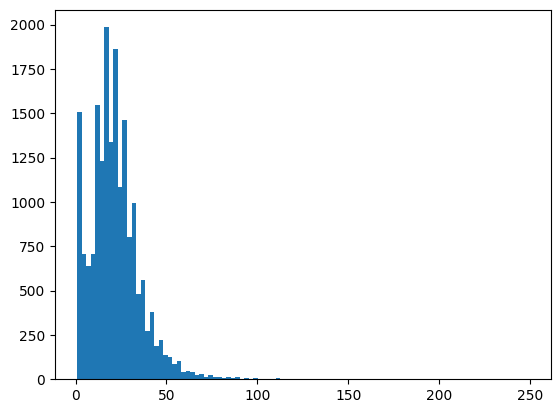

In [ ]:
import matplotlib.pyplot as plt
plt.hist(len_sen, bins=100)
plt.show()

In [ ]:
#get the number of unique words and tags
words = list(set(data['word'].values))
num_words = len(words)
tags = list(set(data['tag'].values))#iob2 tags
num_tags = len(tags)
pos = list(set(data['pos'].values))#iob2 tags
num_pos = len(pos)

In [ ]:
num_tags

10

### Creating the dataset

In [ ]:
xtrain,xtest,ytrain,ytest=process_training_data(sentences,words,tags,pos,len_sen)

In [ ]:
tags_10_train_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
tags_10_val_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest))
tags_10_train_dataset=tags_10_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tags_10_val_dataset=tags_10_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: LSTM Based

In [ ]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
x = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(x)
x = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(x)
outputs = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
tags10_model1 = Model(inputs, outputs)
tags10_model1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_12 (Bidirecti  (None, 98, 128)          62976     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 98, 128)          74496     
 onal)                                                           
                                                                 
 time_distributed_5 (TimeDis  (None, 98, 10)           1290      
 tributed)                                                       
                                                           

In [ ]:
tags10_model1.compile(optimizer='adam', loss=focal_loss(gamma=3), metrics=['accuracy'])

In [ ]:
tags10_history1 = tags10_model1.fit(tags_10_train_dataset,
                    epochs=5,
                    validation_data=tags_10_val_dataset)

Epoch 1/5
499/499 [==============================] - 43s 69ms/step - loss: 0.0020 - accuracy: 0.9708 - val_loss: 0.0012 - val_accuracy: 0.9762
Epoch 2/5
499/499 [==============================] - 10s 21ms/step - loss: 9.1205e-04 - accuracy: 0.9802 - val_loss: 0.0010 - val_accuracy: 0.9779
Epoch 3/5
499/499 [==============================] - 11s 23ms/step - loss: 5.7733e-04 - accuracy: 0.9852 - val_loss: 0.0010 - val_accuracy: 0.9781
Epoch 4/5
499/499 [==============================] - 12s 24ms/step - loss: 3.7773e-04 - accuracy: 0.9891 - val_loss: 0.0013 - val_accuracy: 0.9778
Epoch 5/5
499/499 [==============================] - 10s 20ms/step - loss: 2.9350e-04 - accuracy: 0.9913 - val_loss: 0.0016 - val_accuracy: 0.9777


In [ ]:
y_true,y_pred=get_flattened_preds(tags10_model1,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

      Result       0.55      0.36      0.44      1796
    Location       0.77      0.30      0.43        33
  FutureWork       0.18      0.04      0.07       320
Organization       0.67      0.32      0.43        63
     Process       0.78      0.59      0.67      4424
   Objective       0.00      0.00      0.00       171
    Material       0.69      0.40      0.51       875
      Domain       0.32      0.34      0.33        90
     Problem       0.54      0.46      0.50      1305
           O       0.98      0.99      0.99    266891

    accuracy                           0.98    275968
   macro avg       0.55      0.38      0.44    275968
weighted avg       0.97      0.98      0.98    275968



In [ ]:
get_pred_sentence(tags10_model1,xtest,words,tags)

1/1 [==============================] - 2s 2s/step
Word           True 	 Pred

------------------------------
Post-mortem    Problem	Problem
iris           Problem	Problem
recognition    Problem	Problem
Post-mortem    Problem	Problem
iris           Problem	Problem
recognition    Problem	Problem
has            O	Problem
recently       O	O
gained         O	O
attention      O	O
from           O	O
the            O	O
biometrics     Domain	O
community      O	O
,              O	O
starting       O	O
with           O	O
a              O	O
Master         O	O
's             O	O
thesis         O	O
from           O	O
Boston         Organization	Domain
University     Organization	Domain
[              O	O
1              O	O
]              O	O
and            O	O
studies        O	O
on             O	O
ex             O	O
vivo           O	O
pig            O	O
eyes           O	O
in             O	O
2015           O	O
[              O	O
2              O	O
]              O	O
.              O	O
males          O

In [ ]:
tags10_model1_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                        target_names=tags,
                                                        output_dict=True,
                                                        labels=np.arange(0,len(tags),1))).transpose()

## Model 2: Using LSTM+CRF

In [ ]:
inputs = Input(shape=(max_len, ))
embedding = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
lstm1 = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(embedding)
lstm2 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm1)
logits = TimeDistributed(Dense(num_tags))(lstm2)
crf_layer = CRF(num_tags)
outputs= crf_layer(logits)
tags10_model2 = Model(inputs, outputs)
tags10_model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 98, 98)            1783306   
                                                                 
 bidirectional_14 (Bidirecti  (None, 98, 128)          62976     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 98, 128)          74496     
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDis  (None, 98, 10)           1290      
 tributed)                                                       
                                                           

In [ ]:
tags10_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=crf_layer.loss,
                        metrics=[crf_layer.accuracy])

In [ ]:
tags10_history2 = tags10_model2.fit(tags_10_train_dataset,
                                        epochs=5,
                                        validation_data=tags_10_val_dataset)

Epoch 1/5
499/499 [==============================] - 181s 342ms/step - loss: 14.5450 - viterbi_accuracy: 0.9635 - val_loss: 180.3279 - val_viterbi_accuracy: 0.5013
Epoch 2/5
499/499 [==============================] - 152s 304ms/step - loss: 5.5642 - viterbi_accuracy: 0.9811 - val_loss: 173.7969 - val_viterbi_accuracy: 0.4988
Epoch 3/5
499/499 [==============================] - 152s 304ms/step - loss: 3.3583 - viterbi_accuracy: 0.9869 - val_loss: 168.5266 - val_viterbi_accuracy: 0.0209
Epoch 4/5
499/499 [==============================] - 148s 298ms/step - loss: 2.1814 - viterbi_accuracy: 0.9904 - val_loss: 164.3455 - val_viterbi_accuracy: 0.0193
Epoch 5/5
499/499 [==============================] - 146s 293ms/step - loss: 1.6537 - viterbi_accuracy: 0.9923 - val_loss: 160.6968 - val_viterbi_accuracy: 0.0196


In [ ]:
tags10_model2.evaluate(tags_10_val_dataset)

88/88 [==============================] - 15s 167ms/step - loss: 160.6968 - viterbi_accuracy: 0.0196


[160.69679260253906, 0.01955660991370678]

In [ ]:
y_true,y_pred=get_flattened_preds(tags10_model2,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 7s 56ms/step
              precision    recall  f1-score   support

      Result       0.53      0.38      0.44      1796
    Location       1.00      0.21      0.35        33
  FutureWork       0.34      0.06      0.10       320
Organization       0.57      0.25      0.35        63
     Process       0.73      0.72      0.73      4424
   Objective       0.03      0.01      0.01       171
    Material       0.72      0.51      0.60       875
      Domain       0.42      0.26      0.32        90
     Problem       0.63      0.42      0.50      1305
           O       0.99      0.99      0.99    266891

    accuracy                           0.98    275968
   macro avg       0.60      0.38      0.44    275968
weighted avg       0.98      0.98      0.98    275968



In [ ]:
tags10_model2_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                        target_names=tags,
                                                        output_dict=True,
                                                        labels=np.arange(0,len(tags),1))).transpose()

## Model 3: Using CRFs

In [ ]:
xtrain, xtest, ytrain, ytest=crf_split(sentences)

In [ ]:
import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)
trainer.select('lbfgs')
# Submit training data to the trainer
for xseq,yseq in zip(xtrain,ytrain):
    trainer.append(xseq,yseq)

In [ ]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [ ]:
# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.1,

    # coefficient for L2 penalty
    'c2': 0.01,

    # maximum number of iterations
    'max_iterations': 200,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Provide a file name as a parameter to the train function, such that
# the model will be saved to the file when training is finished
trainer.train('crf_10_tags.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 79330
Seconds required: 1.150

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 247954.531496
Feature norm: 1.000000
Error norm: 125944.347521
Active features: 78503
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 1.053

***** Iteration #2 *****
Loss: 233968.209092
Feature norm: 1.145518
Error norm: 72004.345772
Active features: 73178
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.439

***** Iteration #3 *****
Loss: 222331.248207
Feature norm: 1.238841
Error norm: 68974.923333
Active features: 74197
Line search trials: 1
Line search step: 1.000000
Seconds required

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_10_tags.model')

In [ ]:
# Convert the sequences of tags into a 1-dimensional array
ypred = [tagger.tag(xseq) for xseq in xtest]
predictions = np.array([tag for row in ypred for tag in row])
truths = np.array([tag for row in ytest for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions,target_names=tags))

              precision    recall  f1-score   support

      Result       0.60      0.38      0.46        90
    Location       0.16      0.09      0.12       320
  FutureWork       0.78      0.42      0.55        33
Organization       0.73      0.48      0.58       875
     Process       0.94      0.97      0.95     52505
   Objective       0.22      0.13      0.16       171
    Material       0.83      0.63      0.72        63
      Domain       0.56      0.48      0.52      1305
     Problem       0.78      0.72      0.75      4424
           O       0.47      0.42      0.44      1796

    accuracy                           0.91     61582
   macro avg       0.61      0.47      0.53     61582
weighted avg       0.90      0.91      0.90     61582



In [ ]:
tags10_model3_report=pd.DataFrame(classification_report(truths, predictions,output_dict=True)).transpose()

# Keeping only 5 tags

In [ ]:
labelsToKeep=['Problem','Material','Process','Result','O']
data=data.loc[data['tag'].isin(labelsToKeep)]

In [ ]:
data['tag'].value_counts()

O           350870
Process      28507
Result       11663
Problem       8396
Material      5159
Name: tag, dtype: int64

In [ ]:
data.head()

,File Number,File,Sentence,word,tag,pos
0,0,An_overlapping_community_detection_algorithm_b...,1,The,O,DT
1,0,An_overlapping_community_detection_algorithm_b...,1,growth,O,NN
2,0,An_overlapping_community_detection_algorithm_b...,1,of,O,IN
3,0,An_overlapping_community_detection_algorithm_b...,1,networks,O,NNS
4,0,An_overlapping_community_detection_algorithm_b...,1,is,O,VBZ


# Models using 5 Entities

## Preparing the dataset

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
len_sen=[len(s) for s in sentences]

In [ ]:
import numpy as np
max_len=int(np.percentile(len_sen,99.8))
max_len

98

In [ ]:
num_tags=data['tag'].nunique()

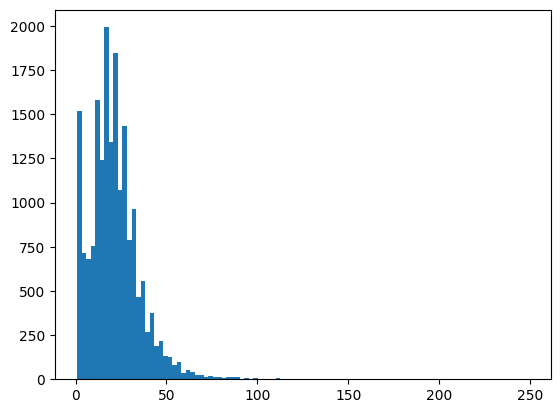

In [ ]:
import matplotlib.pyplot as plt
plt.hist(len_sen, bins=100)
plt.show()

In [ ]:
#get the number of unique words and tags
words = list(set(data['word'].values))
num_words = len(words)
tags = list(set(data['tag'].values))#iob2 tags
num_tags = len(tags)
pos = list(set(data['pos'].values))#iob2 tags
num_pos = len(pos)

In [ ]:
num_tags

5

### Creating the dataset

In [ ]:
xtrain,xtest,ytrain,ytest=process_training_data(sentences,words,tags,pos,len_sen)

In [ ]:
tags_5_train_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
tags_5_val_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest))
tags_5_train_dataset=tags_5_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tags_5_val_dataset=tags_5_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: LSTM Based

In [ ]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
x = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(x)
x = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(x)
outputs = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
tags5_model1 = Model(inputs, outputs)
tags5_model1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 98, 98)            1759884   
                                                                 
 bidirectional_16 (Bidirecti  (None, 98, 128)          62976     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 98, 128)          74496     
 onal)                                                           
                                                                 
 time_distributed_7 (TimeDis  (None, 98, 5)            645       
 tributed)                                                       
                                                           

In [ ]:
tags5_model1.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [ ]:
tags5_history1 = tags5_model1.fit(tags_5_train_dataset,
                    epochs=5,
                    validation_data=tags_5_val_dataset)

Epoch 1/5
499/499 [==============================] - 53s 88ms/step - loss: 0.0038 - accuracy: 0.9743 - val_loss: 0.0026 - val_accuracy: 0.9804
Epoch 2/5
499/499 [==============================] - 10s 20ms/step - loss: 0.0019 - accuracy: 0.9842 - val_loss: 0.0023 - val_accuracy: 0.9825
Epoch 3/5
499/499 [==============================] - 8s 17ms/step - loss: 0.0013 - accuracy: 0.9891 - val_loss: 0.0026 - val_accuracy: 0.9816
Epoch 4/5
499/499 [==============================] - 10s 19ms/step - loss: 9.0593e-04 - accuracy: 0.9925 - val_loss: 0.0033 - val_accuracy: 0.9788
Epoch 5/5
499/499 [==============================] - 9s 19ms/step - loss: 7.7848e-04 - accuracy: 0.9935 - val_loss: 0.0037 - val_accuracy: 0.9816


In [ ]:
y_true,y_pred=get_flattened_preds(tags5_model1,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

      Result       0.56      0.37      0.44      1672
     Process       0.71      0.76      0.74      4464
    Material       0.60      0.58      0.59       844
     Problem       0.59      0.48      0.53      1280
           O       0.99      0.99      0.99    267610

    accuracy                           0.98    275870
   macro avg       0.69      0.64      0.66    275870
weighted avg       0.98      0.98      0.98    275870



In [ ]:
fpr_dict = {}
# calculate confusion matrix and FPR for each entity
for i,tag in enumerate(tags):
    tn, fp, fn, tp = confusion_matrix(y_true == i, y_pred == i).ravel()
    fpr = fp / (fp + tn)
    fpr_dict[tag] = fp

In [ ]:
fpr_dict

{'Result': 484, 'Process': 1363, 'Material': 330, 'Problem': 432, 'O': 2466}

In [ ]:
get_pred_sentence(tags5_model1,xtest,words,tags)

1/1 [==============================] - 0s 23ms/step
Word           True 	 Pred

------------------------------
This           O	O
algorithm      O	O
classifies     O	O
entities       O	O
by             O	O
determining    O	O
the            O	O
maximum        O	O
margin         O	O
hyperplane     O	O
,              O	O
which          O	O
utilises       O	O
a              O	O
maximum        O	O
distance       O	O
between        O	O
the            O	O
hyperplane     O	O
and            O	O
the            O	O
nearest        O	O
sample         O	O
from           O	O
either         O	O
the            O	O
spam           O	O
or             O	O
non-spam       O	O
class          O	O
.              O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          O	O
males          

In [ ]:
tags5_model1_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                       target_names=tags,
                                                       output_dict=True,
                                                       labels=np.arange(0,len(tags),1))).transpose()

## Model 2: Using LSTM+CRF

In [ ]:
inputs = Input(shape=(max_len, ))
embedding = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(inputs)
lstm1 = Bidirectional(GRU(units=64, return_sequences=True,activation='tanh'))(embedding)
lstm2 = Bidirectional(GRU(units=64,return_sequences=True,activation='tanh'))(lstm1)
logits = TimeDistributed(Dense(num_tags))(lstm2)
crf_layer = CRF(num_tags)
outputs= crf_layer(logits)
tags5_model2 = Model(inputs, outputs)
tags5_model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 98, 98)            1759884   
                                                                 
 bidirectional_18 (Bidirecti  (None, 98, 128)          62976     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 98, 128)          74496     
 onal)                                                           
                                                                 
 time_distributed_8 (TimeDis  (None, 98, 5)            645       
 tributed)                                                       
                                                           

In [ ]:
tags5_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=crf_layer.loss,
                        metrics=[crf_layer.accuracy])

In [ ]:
tags5_history2 = tags5_model2.fit(tags_5_train_dataset,
                                        epochs=5,
                                        validation_data=tags_5_val_dataset)

Epoch 1/5
499/499 [==============================] - 180s 340ms/step - loss: 8.3736 - viterbi_accuracy: 0.9766 - val_loss: 41.9469 - val_viterbi_accuracy: 0.9798
Epoch 2/5
499/499 [==============================] - 144s 288ms/step - loss: 3.5256 - viterbi_accuracy: 0.9856 - val_loss: 36.7812 - val_viterbi_accuracy: 0.9807
Epoch 3/5
499/499 [==============================] - 145s 290ms/step - loss: 2.0049 - viterbi_accuracy: 0.9907 - val_loss: 32.9066 - val_viterbi_accuracy: 0.9810
Epoch 4/5
499/499 [==============================] - 143s 286ms/step - loss: 1.3527 - viterbi_accuracy: 0.9937 - val_loss: 30.1271 - val_viterbi_accuracy: 0.9769
Epoch 5/5
499/499 [==============================] - 142s 285ms/step - loss: 1.0975 - viterbi_accuracy: 0.9946 - val_loss: 27.4809 - val_viterbi_accuracy: 0.9770


In [ ]:
tags5_model2.evaluate(tags_5_val_dataset)

88/88 [==============================] - 14s 155ms/step - loss: 27.4809 - viterbi_accuracy: 0.9770


[27.480928421020508, 0.9769742488861084]

In [ ]:
y_true,y_pred=get_flattened_preds(tags5_model2,xtest,ytest)
print(classification_report(y_true,y_pred,target_names=tags,labels=np.arange(0,len(tags),1)))

88/88 [==============================] - 7s 67ms/step
              precision    recall  f1-score   support

      Result       0.48      0.49      0.49      1672
     Process       0.73      0.78      0.75      4464
    Material       0.60      0.63      0.62       844
     Problem       0.46      0.58      0.51      1280
           O       0.99      0.99      0.99    267610

    accuracy                           0.98    275870
   macro avg       0.65      0.69      0.67    275870
weighted avg       0.98      0.98      0.98    275870



In [ ]:
tags5_model2_report=pd.DataFrame(classification_report(y_true,y_pred,
                                                       target_names=tags,
                                                       output_dict=True,
                                                       labels=np.arange(0,len(tags),1))).transpose()

## Model 3: Using CRFs

In [ ]:
xtrain, xtest, ytrain, ytest=crf_split(sentences)

In [ ]:
import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)
trainer.select('lbfgs')
# Submit training data to the trainer
for xseq,yseq in zip(xtrain,ytrain):
    trainer.append(xseq,yseq)

In [ ]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [ ]:
# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.1,

    # coefficient for L2 penalty
    'c2': 0.01,

    # maximum number of iterations
    'max_iterations': 200,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Provide a file name as a parameter to the train function, such that
# the model will be saved to the file when training is finished
trainer.train('crf_5_tags.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 73171
Seconds required: 0.949

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 194045.114466
Feature norm: 1.000000
Error norm: 74952.559583
Active features: 72496
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 0.650

***** Iteration #2 *****
Loss: 188764.677011
Feature norm: 0.951627
Error norm: 59979.995436
Active features: 67541
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.338

***** Iteration #3 *****
Loss: 176611.779152
Feature norm: 0.892874
Error norm: 70341.560924
Active features: 64103
Line search trials: 1
Line search step: 1.000000
Seconds required 

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_5_tags.model')

In [ ]:
# Convert the sequences of tags into a 1-dimensional array
ypred = [tagger.tag(xseq) for xseq in xtest]
predictions = np.array([tag for row in ypred for tag in row])
truths = np.array([tag for row in ytest for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions))

              precision    recall  f1-score   support

    Material       0.73      0.57      0.64       844
           O       0.95      0.97      0.96     51511
     Problem       0.63      0.45      0.53      1280
     Process       0.78      0.73      0.76      4464
      Result       0.47      0.43      0.45      1672

    accuracy                           0.92     59771
   macro avg       0.71      0.63      0.67     59771
weighted avg       0.91      0.92      0.92     59771



In [ ]:
tags5_model3_report=pd.DataFrame(classification_report(truths, predictions,output_dict=True)).transpose()

# Combined Results

In [ ]:
# classification report dicts
all_tags_model1_dict=dict(all_tags_model1_report.loc['macro avg'])
all_tags_model1_dict['Model']='All Tags LSTM Model'
all_tags_model2_dict=dict(all_tags_model2_report.loc['macro avg'])
all_tags_model2_dict['Model']='All Tags LSTM+CRF Model'
all_tags_model3_dict=dict(all_tags_model3_report.loc['macro avg'])
all_tags_model3_dict['Model']='All Tags CRF Model'

tags31_model1_dict=dict(tags31_model1_report.loc['macro avg'])
tags31_model1_dict['Model']='Tags 31 LSTM Model'
tags31_model2_dict=dict(tags31_model2_report.loc['macro avg'])
tags31_model2_dict['Model']='Tags 31 LSTM+CRF Model'
tags31_model3_dict=dict(tags31_model3_report.loc['macro avg'])
tags31_model3_dict['Model']='Tags 31 Model CRF Model'

tags10_model1_dict=dict(tags10_model1_report.loc['macro avg'])
tags10_model1_dict['Model']='Tags 10 LSTM Model'
tags10_model2_dict=dict(tags10_model2_report.loc['macro avg'])
tags10_model2_dict['Model']='Tags 10 Model LSTM+CRF Model'
tags10_model3_dict=dict(tags10_model3_report.loc['macro avg'])
tags10_model3_dict['Model']='Tags 10 Model CRF Model'

tags5_model1_dict=dict(tags5_model1_report.loc['macro avg'])
tags5_model1_dict['Model']='Tags 5 LSTM Model'
tags5_model2_dict=dict(tags5_model2_report.loc['macro avg'])
tags5_model2_dict['Model']='Tags 5 LSTM+CRF Model'
tags5_model3_dict=dict(tags5_model3_report.loc['macro avg'])
tags5_model3_dict['Model']='Tags 5 CRF Model'


In [ ]:
all_tags_macro_avg_df=pd.DataFrame([all_tags_model1_dict,all_tags_model2_dict,all_tags_model3_dict])
tags31_macro_avg_df=pd.DataFrame([tags31_model1_dict,tags31_model2_dict,tags31_model3_dict])
tags10_macro_avg_df=pd.DataFrame([tags10_model1_dict,tags10_model2_dict,tags10_model3_dict])
tags5_macro_avg_df=pd.DataFrame([tags5_model1_dict,tags5_model2_dict,tags5_model3_dict])

# combine all models into one dataframe
macro_avg_df=pd.concat([all_tags_macro_avg_df,tags31_macro_avg_df,tags10_macro_avg_df,tags5_macro_avg_df],axis=0)
macro_avg_df.set_index('Model',inplace=True)

all_tags_macro_avg_df.set_index('Model',inplace=True)
tags31_macro_avg_df.set_index('Model',inplace=True)
tags10_macro_avg_df.set_index('Model',inplace=True)
tags5_macro_avg_df.set_index('Model',inplace=True)

## Results by tags

In [ ]:
all_tags_macro_avg_df

,precision,recall,f1-score,support
Model,,,,
All Tags LSTM Model,0.174497,0.116269,0.131051,275968.0
All Tags LSTM+CRF Model,0.279293,0.148978,0.166973,275968.0
All Tags CRF Model,0.407431,0.261066,0.291185,61582.0


In [ ]:
tags31_macro_avg_df

,precision,recall,f1-score,support
Model,,,,
Tags 31 LSTM Model,0.312532,0.219344,0.245193,275968.0
Tags 31 LSTM+CRF Model,0.436824,0.280284,0.319454,275968.0
Tags 31 Model CRF Model,0.473093,0.326788,0.373177,61582.0


In [ ]:
tags10_macro_avg_df

,precision,recall,f1-score,support
Model,,,,
Tags 10 LSTM Model,0.548906,0.381306,0.436883,275968.0
Tags 10 Model LSTM+CRF Model,0.596135,0.381407,0.439247,275968.0
Tags 10 Model CRF Model,0.607836,0.472134,0.525557,61582.0


In [ ]:
tags5_macro_avg_df

,precision,recall,f1-score,support
Model,,,,
Tags 5 LSTM Model,0.690454,0.638183,0.659129,275870.0
Tags 5 LSTM+CRF Model,0.651095,0.693577,0.670632,275870.0
Tags 5 CRF Model,0.711731,0.630653,0.666186,59771.0


## Combined results of all the models

In [ ]:
macro_avg_df

,precision,recall,f1-score,support
Model,,,,
All Tags LSTM Model,0.174497,0.116269,0.131051,275968.0
All Tags LSTM+CRF Model,0.279293,0.148978,0.166973,275968.0
All Tags CRF Model,0.407431,0.261066,0.291185,61582.0
Tags 31 LSTM Model,0.312532,0.219344,0.245193,275968.0
Tags 31 LSTM+CRF Model,0.436824,0.280284,0.319454,275968.0
Tags 31 Model CRF Model,0.473093,0.326788,0.373177,61582.0
Tags 10 LSTM Model,0.548906,0.381306,0.436883,275968.0
Tags 10 Model LSTM+CRF Model,0.596135,0.381407,0.439247,275968.0
Tags 10 Model CRF Model,0.607836,0.472134,0.525557,61582.0
